### 0. 라이브러리 불러오기

In [1]:
from shapely.geometry import Point, MultiPoint, Polygon as sPolygon, MultiPolygon
from folium import Map, Polygon, CircleMarker, Choropleth
from shapely.ops import transform, unary_union
from copy import deepcopy
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import pyproj
import json

seed = 0
random.seed(seed)
np.random.seed(seed)

### 1. 데이터 불러오기

In [2]:
sex_age_per_pop = pd.read_csv('data/1.김해시_성연령별_유동인구.csv')
public_wifi_zone = pd.read_csv('data/4.김해시_공공wifi_위치정보.csv')
public_wifi_usage = pd.read_csv('data/5.김해시_공공wifi_사용량.csv')
cctv = pd.read_csv('data/6.김해시_CCTV설치현황.csv')
bell = pd.read_csv('data/7.김해시_안전비상벨설치현황.csv')
secu_light = pd.read_csv('data/8.김해시_보안등설치현황.csv')
traffic_light = pd.read_csv('data/9.김해시_신호등설치현황.csv')
park = pd.read_csv('data/17.김해시_공원현황.csv')
travel_spot = gpd.read_file('data/18.김해시_주변관광지정보(문화재).geojson')
store = pd.read_csv('data/19.김해시_상권정보.csv')
raw_boundary = gpd.read_file('data/21.김해시_행정경계.geojson')
raw_grid = gpd.read_file('data/22.김해시_격자(매핑용).geojson')

#### 1-1. 좌표계 변환기 설정

In [3]:
transformer = pyproj.Transformer.from_crs(4326, 5179, always_xy=True).transform

### 2. 김해시 공공 wifi 데이터 전처리

#### 2-1. 공공 wifi zone과 공공 wifi 사용량 데이터 AP 유무 비교

In [4]:
public_wifi_zone[~public_wifi_zone['AP_nm'].isin(public_wifi_usage['AP_nm'])]

mc_nm sc_nm  sido sgg_nm                addr  inst_plc inst_loc  \
50  지역문화시설  도시공원  경상남도    김해시  경상남도 김해시 북부동 429-2       수릉원     방범폴1   
51  지역문화시설  도시공원  경상남도    김해시  경상남도 김해시 북부동 429-2       수릉원     방범폴2   
73  관광편의시설    기타  경상남도    김해시    경상남도 김해시 외동 1264  봉황역 타고가야        -   

                      AP_nm        lat         lon in_or_out  
50  Park_sureungwon _CCTV01  35.236000  128.875500        옥외  
51  Park_sureungwon _CCTV02  35.227167  128.873806        옥외  
73  Terminal_Shinsegae_bike  35.227111  128.875167        옥외

* wifi zone은 있으나, 사용량이 없는 wifi zone

#### 2-2. AP 이름 문자열로 재확인

In [5]:
### wifi zone
display(public_wifi_zone[public_wifi_zone['AP_nm'].str.contains('Park_sureungwon')])

### wifi usage
display(public_wifi_usage[public_wifi_usage['AP_nm'].str.contains('Park_sureungwon')])

mc_nm sc_nm  sido sgg_nm                addr inst_plc inst_loc  \
50  지역문화시설  도시공원  경상남도    김해시  경상남도 김해시 북부동 429-2      수릉원     방범폴1   
51  지역문화시설  도시공원  경상남도    김해시  경상남도 김해시 북부동 429-2      수릉원     방범폴2   

                      AP_nm        lat         lon in_or_out  
50  Park_sureungwon _CCTV01  35.236000  128.875500        옥외  
51  Park_sureungwon _CCTV02  35.227167  128.873806        옥외

AP_nm         period  user_cnt  tot_data  tot_use_tm  \
40   Park_sureungwon_CCTV01  202201~202205      1346   7081.10      137390   
43   Park_sureungwon_CCTV02  202201~202205      1354  17749.79      134634   
115  Park_sureungwon_CCTV01  202206~202212      1278   9069.89      186528   
122  Park_sureungwon_CCTV02  202206~202212      1279  26213.33      153659   
184  Park_sureungwon_CCTV02  202301~202306      1175  30174.32      183285   
189  Park_sureungwon_CCTV01  202301~202306      1248  20557.67      160998   

     avg_use_tm   avg_data  
40   102.072808   5.260847  
43    99.434269  13.109151  
115  145.953052   7.096941  
122  120.139953  20.495176  
184  155.987234  25.680272  
189  129.004808  16.472492

* wifi 사용량 데이터와 비교했을 때, 'Park_sureungwon' 가 포함된 AP이름에 띄어쓰기가 포함되어 있음

In [6]:
### 띄어쓰기 제거
public_wifi_zone['AP_nm'] = public_wifi_zone['AP_nm'].map(lambda x: x.replace(' ', '') if 'Park_sureungwon' in x else x)

### 띄어쓰기 제거 후 AP 유무 재확인
public_wifi_zone[~public_wifi_zone['AP_nm'].isin(public_wifi_usage['AP_nm'])]

mc_nm sc_nm  sido sgg_nm              addr  inst_plc inst_loc  \
73  관광편의시설    기타  경상남도    김해시  경상남도 김해시 외동 1264  봉황역 타고가야        -   

                      AP_nm        lat         lon in_or_out  
73  Terminal_Shinsegae_bike  35.227111  128.875167        옥외

In [7]:
### wifi zone
display(public_wifi_zone[public_wifi_zone['AP_nm'].str.contains('Terminal')])

### wifi usage
display(public_wifi_usage[public_wifi_usage['AP_nm'].str.contains('Terminal')])

mc_nm sc_nm  sido sgg_nm              addr  inst_plc inst_loc  \
73  관광편의시설    기타  경상남도    김해시  경상남도 김해시 외동 1264  봉황역 타고가야        -   

                      AP_nm        lat         lon in_or_out  
73  Terminal_Shinsegae_bike  35.227111  128.875167        옥외

AP_nm         period  user_cnt  tot_data  tot_use_tm  \
23   Terminal_shinsegae_bike  202201~202205     12595  12261.28      296041   
97   Terminal_shinsegae_bike  202206~202212      8964  13459.49      319455   
175  Terminal_shinsegae_bike  202301~202306      7579  66080.43      271662   

     avg_use_tm  avg_data  
23    23.504645  0.973504  
97    35.637550  1.501505  
175   35.844043  8.718885

* wifi 사용량 데이터와 비교했을 때, 'shinsegae'의 맨 앞글자가 대문자로 표시되어 있음

In [8]:
### wifi zone의 'Terminal_Shinsegae_bike'의 'S'를 대문자에서 소문자로 변경
public_wifi_zone['AP_nm'] = public_wifi_zone['AP_nm'].map(lambda x: 'Terminal_shinsegae_bike' if 'Terminal_Shinsegae_bike' == x else x)

### 소문자로 변경 후 AP 유무 재확인
public_wifi_zone[~public_wifi_zone['AP_nm'].isin(public_wifi_usage['AP_nm'])]

Empty DataFrame
Columns: [mc_nm, sc_nm, sido, sgg_nm, addr, inst_plc, inst_loc, AP_nm, lat, lon, in_or_out]
Index: []

* 모든 wifi zone에 사용량이 존재하는 것을 확인할 수 있음

### 3. wifi zone 데이터에 wifi 사용량 맵핑
* 5.김해시_공공wifi_사용량 데이터 중 2022년 12월이 포함된 2022년 06월 ~ 2022년 12월만 사용

In [9]:
public_wifi_usage_202212 = public_wifi_usage[public_wifi_usage['period'] == '202206~202212'].reset_index(drop=True)
public_wifi_usage_202212.head()

AP_nm         period  user_cnt    tot_data  \
0          Street_naeoedong_NHbank02  202206~202212      8944   107904.45   
1     Street_macdonald_trafficpole02  202206~202212      9773    62374.69   
2       Street_busanbank_trafficpole  202206~202212      7592  2299155.87   
3  Crossroad_naeoecenter_trafficpole  202206~202212     10624    93687.71   
4   Firestation_naeoe119_trafficpole  202206~202212      8560   126856.52   

   tot_use_tm  avg_use_tm    avg_data  
0     1108759  123.966793   12.064451  
1     1101898  112.749207    6.382348  
2     1093099  143.980374  302.839287  
3      938663   88.353069    8.818497  
4      864216  100.959813   14.819687

In [10]:
public_wifi = pd.merge(public_wifi_zone, public_wifi_usage_202212, on='AP_nm')
print(public_wifi.shape)
public_wifi.head()

(74, 17)


mc_nm sc_nm  sido sgg_nm                 addr inst_plc inst_loc  \
0  관광편의시설  도시공원  경상남도    김해시  경상남도 김해시 내외동 1045-2     연지공원      시계탑   
1  관광편의시설  도시공원  경상남도    김해시     경상남도 김해시 내외동 115     연지공원     풍력폴1   
2  관광편의시설  도시공원  경상남도    김해시     경상남도 김해시 내외동 115     연지공원     풍력폴2   
3  관광편의시설  도시공원  경상남도    김해시     경상남도 김해시 내외동 113     연지공원   공원등38번   
4  관광편의시설  도시공원  경상남도    김해시    경상남도 김해시 내동 106-1     연지공원     조각공원   

                    AP_nm        lat         lon in_or_out         period  \
0  Park_yeonji_clocktower  35.247250  128.868417        옥외  202206~202212   
1  Park_yeonji_windpole01  35.247056  128.868472        옥외  202206~202212   
2  Park_yeonji_windpole02  35.247056  128.868472        옥외  202206~202212   
3  Park_yeonji_38parklamp  35.245194  128.870444        옥외  202206~202212   
4   Park_yeonji_jogakpark  35.245417  128.868750        옥외  202206~202212   

   user_cnt   tot_data  tot_use_tm  avg_use_tm   avg_data  
0      2684   11285.23      294347  109.667288   4.204631  
1      2651    3883.06       40066   15.113542   1.464753  
2      2206   28425.53      177213   80.332276  12.885553  
3      3973    3121.33      147666   37.167380   0.785636  
4      3279  134222.08       76184   23.233913  40.933846

### 4. 행정경계 데이터에서 내외동/회현동만 추출

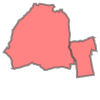

In [11]:
filterd_boundary = raw_boundary[raw_boundary['ADM_DR_NM'].isin(['내외동', '회현동'])]
filterd_boundary_geom = filterd_boundary['geometry'].tolist()
boundary = MultiPolygon(filterd_boundary_geom)
boundary

#### 4-1. 내외동/회현동 위치 시각화

In [12]:
m = Map(location=[35.237, 128.865], zoom_start=14)

for b in boundary.geoms:
    geometry = list(map(lambda x: x[::-1], list(b.exterior.coords)))
    Polygon(locations=geometry, fill=True).add_to(m)

display(m)

### 5. 김해시 공공 wifi 위치 및 커버리지 범위 시각화

In [13]:
for row in public_wifi.itertuples():
    lon, lat = transformer(row.lon, row.lat)
    point = Point(lon, lat)
    buffer = point.buffer(25)
    buffer_4326 = list(map(lambda p: transformer(p[0], p[1], direction='INVERSE'), list(buffer.exterior.coords)))
    buffer_geom = list(map(lambda x: x[::-1], list(buffer_4326)))
    Polygon(locations=buffer_geom, color='red').add_to(m)

display(m)

### 6. 100m 격자 데이터에서 내외동/회현동 부분만 추출

In [14]:
filtered_grid_geom = list(filter(lambda x: not x[1].intersection(boundary).is_empty, raw_grid.values))
filtered_grid_gdf = gpd.GeoDataFrame(filtered_grid_geom, columns=['gid', 'geometry'])

### 김해시 전체 격자 수와 내외동/회현동 부분의 격자 수 비교
len(raw_grid), len(filtered_grid_geom)

(46883, 732)

In [15]:
for grid in filtered_grid_gdf.itertuples():
    geometry = list(map(lambda x: x[::-1], list(grid.geometry.exterior.coords)))
    Polygon(locations=geometry).add_to(m)

display(m)

### 7. 내외동/회현동 100m x 100m 격자를 50m x 50m 격자로 분할
* 1. 유동인구 데이터는 50m x 50m 되어 있기 때문
* 2. 공공 wifi를 최적의 위치로 재배치 하기 위해 작은 격자로 분할하여 분석 진행

#### 7-1. 격자 분할

In [16]:
total_grid = []

for grid in filtered_grid_gdf.itertuples():
    grid_geometry = grid.geometry
    grid_geometry_to_meter = transform(transformer, grid_geometry)
    bbox = grid_geometry_to_meter.bounds
    
    ### 100m x 100m 격자를 4등분 하여 50m x 50m 격자로 분할
    x_split = int(int(bbox[0] + bbox[2]) / 2)
    y_split = int(int(bbox[1] + bbox[3]) / 2)
    
    '''
    (bbox[0], bbox[1]), (bbox[0], y_split), (bbox[0], bbox[3])
    
    (x_split, bbox[1]), (x_split, y_split), (x_split, bbox[3])
    
    (bbox[2], bbox[1]), (bbox[2], y_split), (bbox[2], bbox[3])
    '''
    
    x_lst = [int(bbox[0]), x_split, int(bbox[2])]
    y_lst = [int(bbox[1]), y_split, int(bbox[3])]
    
    count = 1
    for x_index in range(len(x_lst) - 1):
        for y_index in range(len(y_lst) - 1):
            x = x_lst[x_index]
            y = y_lst[y_index]
            x_diff = x_lst[x_index + 1] - x
            y_diff = y_lst[y_index + 1] - y
            corners_5179 = [(x, y), (x + x_diff, y), (x + x_diff, y + y_diff), (x, y + y_diff)]
            corners_4326 = [transformer(c[0], c[1], direction='INVERSE') for c in corners_5179]
            polygon = sPolygon(corners_4326)
            grid_to_dict = grid._asdict().copy()
            new_grid_dict = {**grid_to_dict}
            new_grid_dict['sub_index'] = count
            new_grid_dict['geometry'] = polygon
            total_grid.append(new_grid_dict)
            count += 1

total_grid = gpd.GeoDataFrame(total_grid)
total_grid = total_grid.drop(columns='Index')
total_grid.head()

gid                                           geometry  sub_index
0  마라229939  POLYGON ((128.85062 35.23297, 128.85117 35.232...          1
1  마라229939  POLYGON ((128.85063 35.23342, 128.85118 35.233...          2
2  마라229939  POLYGON ((128.85117 35.23297, 128.85172 35.232...          3
3  마라229939  POLYGON ((128.85118 35.23342, 128.85173 35.233...          4
4  마라239955  POLYGON ((128.86184 35.24726, 128.86240 35.247...          1

In [17]:
total_grid.shape

(2928, 3)

#### 7-2. 분할된 격자 검증

In [18]:
print(f'내외동/회현동 100m x 100m 격자 수 : {len(filtered_grid_gdf)}')
print(f'내외동/회현동  50m x  50m 격자 수 : {len(total_grid)}')
print(f'{len(filtered_grid_gdf)} x 4등분 = {len(total_grid)}')

내외동/회현동 100m x 100m 격자 수 : 732
내외동/회현동  50m x  50m 격자 수 : 2928
732 x 4등분 = 2928


#### 7-3. 분할된 격자 시각화

In [19]:
m = Map(location=[35.237, 128.865], zoom_start=14)

### 내외동/회현동 행정 구역
for b in boundary.geoms:
    geometry = list(map(lambda x: x[::-1], list(b.exterior.coords)))
    Polygon(locations=geometry, fill=True).add_to(m)

### 유동인구가 있는 50m x 50m 격자
for grid in total_grid.itertuples():
    geometry = list(map(lambda x: x[::-1], list(grid.geometry.exterior.coords)))
    Polygon(locations=geometry).add_to(m)

### 공공 wifi 위치 및 커버리지
for row in public_wifi.itertuples():
    lon, lat = transformer(row.lon, row.lat)
    point = Point(lon, lat)
    buffer = point.buffer(25)
    buffer_4326 = list(map(lambda p: transformer(p[0], p[1], direction='INVERSE'), list(buffer.exterior.coords)))
    buffer_geom = list(map(lambda x: x[::-1], list(buffer_4326)))
    Polygon(locations=buffer_geom, color='red').add_to(m)

display(m)

### 8. 각 격자 중 성연령별 유동인구가 존재하는 격자만 필터 (2022년 12월만 사용)

#### 8-1. 2022년 12월 유동인구만 필터

In [20]:
### 2022년 12월 필터
sex_age_per_pop_2022_12 = sex_age_per_pop[sex_age_per_pop['STD_YM'] == 202212].reset_index(drop=True)
sex_age_per_pop_2022_12.head()

STD_YM  m_10g_pop  m_20g_pop  m_30g_pop  m_40g_pop  m_50g_pop  m_60g_pop  \
0  202212        0.0        0.0        0.0       0.04       0.04       0.04   
1  202212        0.0        0.0        0.0       0.02       0.04       0.02   
2  202212        0.0        0.0        0.0       0.00       0.04       0.02   
3  202212        0.0        0.0        0.0       0.02       0.04       0.04   
4  202212        0.0        0.0        0.0       0.04       0.04       0.04   

   w_10g_pop  w_20g_pop  w_30g_pop  w_40g_pop  w_50g_pop  w_60g_pop  \
0        0.0        0.0        0.0        0.0       0.02       0.02   
1        0.0        0.0        0.0        0.0       0.00       0.00   
2        0.0        0.0        0.0        0.0       0.00       0.00   
3        0.0        0.0        0.0        0.0       0.02       0.02   
4        0.0        0.0        0.0        0.0       0.02       0.02   

          lon        lat  
0  128.693250  35.304315  
1  128.693257  35.304766  
2  128.693263  35.305216  
3  128.693270  35.305667  
4  128.693276  35.306118

#### 8-2. 각 행별로 인구 비율 합 계산

In [21]:
### 각 행별로 인구 비율 합 계산
total_sex_age_per_pop_2022_12 = sex_age_per_pop_2022_12.copy()
total_sex_age_per_pop_2022_12['pop'] = total_sex_age_per_pop_2022_12.apply(lambda x: x[1:-2].sum(), axis=1)

### 년월, 인구비율, 위도, 경도 열만 추출
total_sex_age_per_pop_2022_12 = total_sex_age_per_pop_2022_12[['STD_YM', 'pop', 'lat', 'lon']]

total_sex_age_per_pop_2022_12.head()

STD_YM   pop        lat         lon
0  202212  0.16  35.304315  128.693250
1  202212  0.08  35.304766  128.693257
2  202212  0.06  35.305216  128.693263
3  202212  0.14  35.305667  128.693270
4  202212  0.16  35.306118  128.693276

#### 8-3. 50m x 50m 격자 중 유동인구가 없는 격자 제거

In [22]:
### 유동인구의 위/경도를 geometry(Multi Point) 형식으로 변환
pop_location = []
for row in tqdm(total_sex_age_per_pop_2022_12.itertuples(), total=len(total_sex_age_per_pop_2022_12)):
    lat, lon = row.lat, row.lon
    p = Point(lon, lat)
    pop_location.append(p)

# pop_multi_point = MultiPoint(pop_location)
total_sex_age_per_pop_2022_12['geometry'] = pop_location
total_sex_age_per_pop_2022_12 = gpd.GeoDataFrame(total_sex_age_per_pop_2022_12)

100%|██████████| 75505/75505 [00:01<00:00, 56358.11it/s]


In [23]:
total_grid.shape, total_sex_age_per_pop_2022_12.shape

((2928, 3), (75505, 5))

In [24]:
total_grid1 = gpd.sjoin(total_grid, total_sex_age_per_pop_2022_12, how='left')
total_grid1['pop'] = total_grid1['pop'].fillna(0)

print(total_grid1.shape)
total_grid1.head()

(2928, 8)


gid                                           geometry  sub_index  \
0  마라229939  POLYGON ((128.85062 35.23297, 128.85117 35.232...          1   
1  마라229939  POLYGON ((128.85063 35.23342, 128.85118 35.233...          2   
2  마라229939  POLYGON ((128.85117 35.23297, 128.85172 35.232...          3   
3  마라229939  POLYGON ((128.85118 35.23342, 128.85173 35.233...          4   
4  마라239955  POLYGON ((128.86184 35.24726, 128.86240 35.247...          1   

   index_right    STD_YM     pop        lat         lon  
0      44936.0  202212.0  593.52  35.233230  128.851000  
1      44937.0  202212.0  235.84  35.233681  128.851007  
2      45152.0  202212.0  273.33  35.233224  128.851549  
3      45153.0  202212.0  510.37  35.233675  128.851557  
4      48419.0  202212.0    1.56  35.247531  128.862228

In [25]:
### 유동인구의 위/경도와 50m x 50m로 분할된 격자를 통해 유동인구가 없는 격자 제거

new_total_grid = total_grid1[total_grid1['pop'] != 0]
new_total_grid = new_total_grid.drop(columns=['index_right', 'STD_YM', 'lat', 'lon'], axis=1).reset_index(drop=True)
display(new_total_grid)

gid                                           geometry  sub_index  \
0     마라229939  POLYGON ((128.85062 35.23297, 128.85117 35.232...          1   
1     마라229939  POLYGON ((128.85063 35.23342, 128.85118 35.233...          2   
2     마라229939  POLYGON ((128.85117 35.23297, 128.85172 35.232...          3   
3     마라229939  POLYGON ((128.85118 35.23342, 128.85173 35.233...          4   
4     마라239955  POLYGON ((128.86184 35.24726, 128.86240 35.247...          1   
...        ...                                                ...        ...   
2553  마라248950  POLYGON ((128.87222 35.24309, 128.87277 35.243...          4   
2554  마라257931  POLYGON ((128.88125 35.22540, 128.88181 35.225...          1   
2555  마라257931  POLYGON ((128.88126 35.22585, 128.88182 35.225...          2   
2556  마라257931  POLYGON ((128.88181 35.22540, 128.88236 35.225...          3   
2557  마라257931  POLYGON ((128.88182 35.22585, 128.88237 35.225...          4   

         pop  
0     593.52  
1     235.84  
2     273.33  
3     510.37  
4       1.56  
...      ...  
2553   74.68  
2554  136.32  
2555  596.16  
2556  285.10  
2557  953.89  

[2558 rows x 4 columns]

In [26]:
print(f'제거 전 격자 수: {len(total_grid)}')
print(f'제거 후 격자 수: {len(new_total_grid)}')

제거 전 격자 수: 2928
제거 후 격자 수: 2558


* 성연령별 유동인구 기준으로 유동인구가 없는 370개 격자 제거

#### 8-4. 제거 후 남아있는 격자 시각화

In [27]:
m = Map(location=[35.237, 128.865], zoom_start=14)

### 내외동/회현동 행정 구역
for b in boundary.geoms:
    geometry = list(map(lambda x: x[::-1], list(b.exterior.coords)))
    Polygon(locations=geometry, fill=True).add_to(m)

### 유동인구가 있는 100m x 100m 격자
for grid in new_total_grid.itertuples():
    geometry = list(map(lambda x: x[::-1], list(grid.geometry.exterior.coords)))
    Polygon(locations=geometry).add_to(m)

### 공공 wifi 위치 및 커버리지
for row in public_wifi.itertuples():
    lon, lat = transformer(row.lon, row.lat)
    point = Point(lon, lat)
    buffer = point.buffer(25)
    buffer_4326 = list(map(lambda p: transformer(p[0], p[1], direction='INVERSE'), list(buffer.exterior.coords)))
    buffer_geom = list(map(lambda x: x[::-1], list(buffer_4326)))
    Polygon(locations=buffer_geom, color='red').add_to(m)

display(m)

---

### 세밀한 위/경도 좌표에 공공 wifi를 재배치 하기 어렵다고 판단해 50m x 50m 격자의 중심좌표를 기준으로 재배치
### 따라서 인프라를 고려하기 위해 각 격자의 중심 좌표에서 wifi 커버리지인 25m 버퍼를 기준으로 맵핑 

---

In [28]:
### 각 격자 중심에서 25m 버퍼 생성 -> wifi 커버리지
def get_coverage(grid):
    centroid_5179 = transform(transformer, grid.centroid)
    buffer = centroid_5179.buffer(25)
    buffer_4326 = list(map(lambda p: transformer(p[0], p[1], direction='INVERSE'), list(buffer.exterior.coords)))
    coverage = sPolygon(buffer_4326)
    return coverage

wifi = new_total_grid.copy()
wifi['geometry'] = wifi['geometry'].map(lambda x: get_coverage(x))
wifi.head()

gid                                           geometry  sub_index  \
0  마라229939  POLYGON ((128.85118 35.23319, 128.85117 35.233...          1   
1  마라229939  POLYGON ((128.85118 35.23364, 128.85118 35.233...          2   
2  마라229939  POLYGON ((128.85172 35.23318, 128.85172 35.233...          3   
3  마라229939  POLYGON ((128.85173 35.23364, 128.85173 35.233...          4   
4  마라239955  POLYGON ((128.86240 35.24749, 128.86240 35.247...          1   

      pop  
0  593.52  
1  235.84  
2  273.33  
3  510.37  
4    1.56

### 9. 격자 - 공원 수 & 상권 수 맵핑
* 공원 수 & 상권 수는 각 격자에 포함되는 위치를 기반으로 계산  

In [29]:
### 인프라 수 맵핑 함수
def get_count(grid, locations):
    grid_geometry = grid['geometry'].tolist()
    new_locations = locations.intersection(MultiPolygon(grid_geometry))
    
    count = []
    for idx, row in grid.iterrows():
        res = row['geometry'].intersection(new_locations)
        if res.is_empty:
            count.append(0)
        elif isinstance(res, MultiPoint):
            count.append(len(res.geoms))
        elif isinstance(res, Point):
            count.append(1)
    return count

In [30]:
store_locations = MultiPoint(list(map(lambda x: Point(x[1], x[0]), store[['lat', 'lon']].values)))
park_locations = MultiPoint(list(map(lambda x: Point(x[1], x[0]), park[['lat', 'lon']].values)))

wifi1 = wifi.copy()
wifi1['store_n'] = get_count(wifi1, store_locations)
wifi1['park_n'] = get_count(wifi1, park_locations)
wifi1.head()

gid                                           geometry  sub_index  \
0  마라229939  POLYGON ((128.85118 35.23319, 128.85117 35.233...          1   
1  마라229939  POLYGON ((128.85118 35.23364, 128.85118 35.233...          2   
2  마라229939  POLYGON ((128.85172 35.23318, 128.85172 35.233...          3   
3  마라229939  POLYGON ((128.85173 35.23364, 128.85173 35.233...          4   
4  마라239955  POLYGON ((128.86240 35.24749, 128.86240 35.247...          1   

      pop  store_n  park_n  
0  593.52        1       0  
1  235.84        0       0  
2  273.33        3       0  
3  510.37        3       0  
4    1.56        0       0

### 10. 격자 - 관광지 유무 맵핑
* 관광지 유무는 관광지와 각 격자가 일부 겹치면 있다고 판단

#### 10-1. 관광지 geometry : MultiPolygon -> Polygon

In [31]:
travel_spot_exploded = travel_spot.explode('geometry').reset_index(drop=True)
travel_spot_exploded.head()

cltpty_nm                                           geometry
0  김해 예안리 고분군  POLYGON ((128.96542 35.23878, 128.96576 35.238...
1  김해 예안리 고분군  POLYGON ((128.96655 35.23868, 128.96665 35.238...
2  김해 예안리 고분군  POLYGON ((128.96670 35.23869, 128.96715 35.238...
3  김해 예안리 고분군  POLYGON ((128.96409 35.23879, 128.96409 35.238...
4  김해 예안리 고분군  POLYGON ((128.96333 35.23866, 128.96333 35.238...

#### 10-2. 관광지 위치 시각화
* 파란 polygon : 행정구역
* 빨간 polygon : 관광지

In [32]:
m = Map(location=[35.237, 128.865], zoom_start=14)

### 행정구역 표시 (내외동/회현동)
for b in boundary.geoms:
    geometry = list(map(lambda x: x[::-1], list(b.exterior.coords)))
    Polygon(locations=geometry, fill=True).add_to(m)

for travel in travel_spot_exploded.itertuples():
    geometry = list(map(lambda x: x[::-1], list(travel.geometry.exterior.coords)))
    Polygon(locations=geometry, color='red').add_to(m)

display(m)

#### 10-3. 관광지 유무 맵핑

In [33]:
travel_multi_spot = MultiPolygon(travel_spot_exploded['geometry'].tolist())

exist_travel_spot_lst = []
for grid in wifi1.itertuples():
    grid_geometry = grid.geometry
    intersection_area = grid_geometry.intersection(travel_multi_spot)
    if intersection_area.is_empty:
        exist_travel_spot_lst.append(0)
    else:
        exist_travel_spot_lst.append(1)

wifi1['exist_travel_spot'] = exist_travel_spot_lst
wifi1.head()

gid                                           geometry  sub_index  \
0  마라229939  POLYGON ((128.85118 35.23319, 128.85117 35.233...          1   
1  마라229939  POLYGON ((128.85118 35.23364, 128.85118 35.233...          2   
2  마라229939  POLYGON ((128.85172 35.23318, 128.85172 35.233...          3   
3  마라229939  POLYGON ((128.85173 35.23364, 128.85173 35.233...          4   
4  마라239955  POLYGON ((128.86240 35.24749, 128.86240 35.247...          1   

      pop  store_n  park_n  exist_travel_spot  
0  593.52        1       0                  0  
1  235.84        0       0                  0  
2  273.33        3       0                  0  
3  510.37        3       0                  0  
4    1.56        0       0                  0

### 11. 격자 - 그 외 인프라 요소 맵핑
* CCTV 설치 현황
* 안전비상벨 설치 현황
* 보안등 설치 현황
* 신호등 설치 현황

In [34]:
### cctv 설치 현황 & 안전비상벨 설치 현황 & 신호등 설치 현황 위치
cctv_locations = MultiPoint(list(map(lambda x: Point(x[1], x[0]), cctv[['lat', 'lon']].values)))
bell_locations = MultiPoint(list(map(lambda x: Point(x[1], x[0]), bell[['lat', 'lon']].values)))
traffic_light_locations = MultiPoint(list(map(lambda x: Point(x[1], x[0]), traffic_light[['lat', 'lon']].values)))

In [35]:
### 보안등 설치 현황 데이터의 컬럼 중 설치 개수를 모두 1로 변환
new_secu_light = []
for _, row in secu_light.iterrows():
    row_data = row.to_dict()
    for _ in range(row_data['securitylight_cnt']):
        new_row_data = {**row_data}
        new_row_data['securitylight_cnt'] = 1
        new_secu_light.append(new_row_data)

new_secu_light = pd.DataFrame(new_secu_light)
new_secu_light['securitylight_cnt'].unique()

array([1])

In [36]:
secu_light_locations = MultiPoint(list(map(lambda x: Point(x[1], x[0]), new_secu_light[['lat', 'lon']].values)))

In [37]:
wifi2 = wifi1.copy()
wifi2['cctv_n'] = get_count(wifi2, cctv_locations)
wifi2['bell_n'] = get_count(wifi2, bell_locations)
wifi2['secu_light_n'] = get_count(wifi2, secu_light_locations)
wifi2['traffic_light_n'] = get_count(wifi2, traffic_light_locations)

In [38]:
wifi2.head()

gid                                           geometry  sub_index  \
0  마라229939  POLYGON ((128.85118 35.23319, 128.85117 35.233...          1   
1  마라229939  POLYGON ((128.85118 35.23364, 128.85118 35.233...          2   
2  마라229939  POLYGON ((128.85172 35.23318, 128.85172 35.233...          3   
3  마라229939  POLYGON ((128.85173 35.23364, 128.85173 35.233...          4   
4  마라239955  POLYGON ((128.86240 35.24749, 128.86240 35.247...          1   

      pop  store_n  park_n  exist_travel_spot  cctv_n  bell_n  secu_light_n  \
0  593.52        1       0                  0       1       1             0   
1  235.84        0       0                  0       0       0             0   
2  273.33        3       0                  0       0       0             1   
3  510.37        3       0                  0       0       0             1   
4    1.56        0       0                  0       0       0             0   

   traffic_light_n  
0                0  
1                0  
2                0  
3                0  
4                0

### 12. 인프라 구성 요소가 없는 격자 제거

In [39]:
### 인프라 요소의 합 계산
wifi2.iloc[:, -7:].sum(1).sort_values().value_counts()

0     1346
1      548
2      288
3      155
4      110
5       64
6       29
7        8
8        4
9        3
12       2
11       1
dtype: int64

* 인프라 요소의 합이 0인 격자가 1346개 존재 -> 재배치할 격자에서 제외

In [40]:
wifi3 = wifi2[wifi2.iloc[:, -7:].sum(1) != 0].reset_index(drop=True)
wifi3.head()

gid                                           geometry  sub_index  \
0  마라229939  POLYGON ((128.85118 35.23319, 128.85117 35.233...          1   
1  마라229939  POLYGON ((128.85172 35.23318, 128.85172 35.233...          3   
2  마라229939  POLYGON ((128.85173 35.23364, 128.85173 35.233...          4   
3  마라239955  POLYGON ((128.86296 35.24794, 128.86296 35.247...          4   
4  마라253936  POLYGON ((128.87750 35.23019, 128.87750 35.230...          1   

      pop  store_n  park_n  exist_travel_spot  cctv_n  bell_n  secu_light_n  \
0  593.52        1       0                  0       1       1             0   
1  273.33        3       0                  0       0       0             1   
2  510.37        3       0                  0       0       0             1   
3    4.04        1       0                  0       0       0             0   
4   12.43        0       0                  1       0       0             0   

   traffic_light_n  
0                0  
1                0  
2                0  
3                0  
4                0

### 13. 상권 & 공원 & 관광지 비율과 유동인구에 따른 전체 비율 계산

In [41]:
wifi4 = wifi3.copy()
wifi4['total_n'] = wifi3.iloc[:, -7:-4].sum(1)
wifi4['total_mean_n'] = wifi4['total_n'] / wifi4['total_n'].sum()
wifi4['pop_x_total_mean_n'] = wifi4['pop'] * wifi4['total_mean_n']
wifi4.head()

gid                                           geometry  sub_index  \
0  마라229939  POLYGON ((128.85118 35.23319, 128.85117 35.233...          1   
1  마라229939  POLYGON ((128.85172 35.23318, 128.85172 35.233...          3   
2  마라229939  POLYGON ((128.85173 35.23364, 128.85173 35.233...          4   
3  마라239955  POLYGON ((128.86296 35.24794, 128.86296 35.247...          4   
4  마라253936  POLYGON ((128.87750 35.23019, 128.87750 35.230...          1   

      pop  store_n  park_n  exist_travel_spot  cctv_n  bell_n  secu_light_n  \
0  593.52        1       0                  0       1       1             0   
1  273.33        3       0                  0       0       0             1   
2  510.37        3       0                  0       0       0             1   
3    4.04        1       0                  0       0       0             0   
4   12.43        0       0                  1       0       0             0   

   traffic_light_n  total_n  total_mean_n  pop_x_total_mean_n  
0                0        1      0.000512            0.303746  
1                0        3      0.001535            0.419647  
2                0        3      0.001535            0.783577  
3                0        1      0.000512            0.002068  
4                0        1      0.000512            0.006361

### 14. 전원공급 인프라 요소가 존재하는 격자만 추출

In [42]:
wifi5 = wifi4.copy()
final_wifi_zone = wifi5[wifi5.iloc[:, -7:-3].sum(1) != 0].sort_values('pop_x_total_mean_n', ascending=False).head(30).reset_index(drop=True)
final_wifi_zone

gid                                           geometry  sub_index  \
0   마라256939  POLYGON ((128.88140 35.23330, 128.88139 35.233...          4   
1   마라257941  POLYGON ((128.88252 35.23464, 128.88252 35.234...          3   
2   마라256938  POLYGON ((128.88082 35.23195, 128.88082 35.231...          1   
3   마라238946  POLYGON ((128.86116 35.23939, 128.86116 35.239...          1   
4   마라231939  POLYGON ((128.85337 35.23316, 128.85337 35.233...          1   
5   마라230938  POLYGON ((128.85226 35.23273, 128.85226 35.232...          2   
6   마라258940  POLYGON ((128.88305 35.23373, 128.88305 35.233...          1   
7   마라230940  POLYGON ((128.85284 35.23407, 128.85284 35.234...          3   
8   마라257938  POLYGON ((128.88248 35.23239, 128.88248 35.232...          4   
9   마라256939  POLYGON ((128.88085 35.23331, 128.88085 35.233...          2   
10  마라257941  POLYGON ((128.88197 35.23510, 128.88197 35.235...          2   
11  마라230940  POLYGON ((128.85229 35.23408, 128.85229 35.234...          1   
12  마라256940  POLYGON ((128.88084 35.23376, 128.88084 35.233...          1   
13  마라257938  POLYGON ((128.88193 35.23239, 128.88193 35.232...          2   
14  마라237939  POLYGON ((128.86051 35.23309, 128.86051 35.233...          3   
15  마라239945  POLYGON ((128.86225 35.23848, 128.86225 35.238...          1   
16  마라257941  POLYGON ((128.88253 35.23509, 128.88252 35.235...          4   
17  마라230937  POLYGON ((128.85224 35.23183, 128.85224 35.231...          2   
18  마라231939  POLYGON ((128.85393 35.23361, 128.85393 35.233...          4   
19  마라241949  POLYGON ((128.86452 35.24251, 128.86452 35.242...          2   
20  마라243939  POLYGON ((128.86656 35.23347, 128.86656 35.233...          2   
21  마라256938  POLYGON ((128.88137 35.23195, 128.88137 35.231...          3   
22  마라256934  POLYGON ((128.88132 35.22879, 128.88132 35.228...          4   
23  마라257940  POLYGON ((128.88251 35.23419, 128.88251 35.234...          4   
24  마라243939  POLYGON ((128.86711 35.23346, 128.86711 35.233...          4   
25  마라237940  POLYGON ((128.86053 35.23444, 128.86052 35.234...          4   
26  마라248937  POLYGON ((128.87202 35.23160, 128.87202 35.231...          2   
27  마라244940  POLYGON ((128.86767 35.23436, 128.86767 35.234...          2   
28  마라250932  POLYGON ((128.87414 35.22662, 128.87413 35.226...          1   
29  마라246935  POLYGON ((128.87034 35.22937, 128.87034 35.229...          3   

        pop  store_n  park_n  exist_travel_spot  cctv_n  bell_n  secu_light_n  \
0   1419.95        4       0                  0       0       0             0   
1    607.13        9       0                  0       0       0             3   
2   1169.06        4       0                  0       0       0             1   
3   1795.36        2       0                  0       0       0             0   
4   1190.46        3       0                  0       0       0             1   
5    845.72        4       0                  0       0       0             0   
6    374.74        9       0                  0       1       1             0   
7    654.22        5       0                  0       0       0             1   
8    382.70        8       0                  0       0       0             1   
9    750.03        4       0                  0       0       0             1   
10   448.83        6       0                  0       3       0             0   
11   657.14        4       0                  0       0       0             1   
12   871.08        3       0                  0       0       0             1   
13   646.80        4       0                  0       0       0             1   
14   511.46        5       0                  0       0       0             0   
15   497.70        5       0                  0       0       0             0   
16   401.15        6       0                  0       0       0             1   
17   589.03        4       0                  0       0       0             1   
18   563.81        4       0                  0    

### 15. 유전 알고리즘
* 유전 알고리즘을 사용해 재배치 해야될 공공 WIFI 30곳 추출

In [43]:
def haversine_km(lat1, lon1, lat2, lon2):
    km_constant = 6371 
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance_km = km_constant * c
    return distance_km

In [45]:
### seed 고정
random.seed(seed)
np.random.seed(seed)

### 공공 wifi 전체 수
n = len(public_wifi)

### 유전체
class Chromosome:
    def __init__(self, indexes, fitness=0):
        self.indexes = indexes
        self.fitness = fitness

### 재배치될 wifi 인덱스 마스크 유효성 검사
def check_valid(chromosome):
    chromosome_copy = chromosome.copy()
    large_encoding = None
    small_encoding = None
    if chromosome_copy.sum() > 30:
        large_encoding = 1.0
        small_encoding = 0.0
    elif chromosome_copy.sum() < 30:
        large_encoding = 0.0
        small_encoding = 1.0
    else:
        return chromosome
    
    while chromosome_copy.sum() != 30:
        idx = np.random.randint(n)
        if chromosome_copy[idx] == large_encoding:
            chromosome_copy[idx] = small_encoding
    return chromosome_copy

def init_population(population_size, n):
    pop = []
    while len(pop) != population_size:
        random_index = np.random.choice(range(n), size=30, replace=False)
        mask = np.zeros(n)
        mask[random_index] = 1.
        pop.append(Chromosome(mask))
    return pop

def crossover(p1, p2):
    p1_ = p1.indexes.copy()
    p2_ = p2.indexes.copy()
    
    random_split_index = np.random.choice(len(p1_))
    
    child1 = check_valid(np.concatenate([p1_[:random_split_index], p2_[random_split_index:]]))
    child2 = check_valid(np.concatenate([p2_[:random_split_index], p1_[random_split_index:]]))
    
    child1 = Chromosome(child1)
    child2 = Chromosome(child2)
    return child1, child2

def mutation(p, mutation_rate):
    if random.random() < mutation_rate:
        random_index = np.random.choice(len(p.indexes))
        new_indexes = p.indexes.copy()
        
        if new_indexes[random_index] == 0:
            reverse_index = random.sample(np.where(new_indexes == 1)[0].tolist(), 1)[0]
            new_indexes[random_index] = 1.
            new_indexes[reverse_index] = 0.
        else:
            reverse_index = random.sample(np.where(new_indexes == 0)[0].tolist(), 1)[0]
            new_indexes[random_index] = 0.
            new_indexes[reverse_index] = 1.
        
        p.indexes = check_valid(new_indexes)
    return p

def fitness_fn(pop):
    avg_fit = 0
    for p in pop:
        ### 재배치 해야할 공공 wifi
        relocation_wifi = public_wifi.copy()
        relocation_wifi['mask'] = p.indexes
        filtered_relocation_wifi = relocation_wifi[relocation_wifi['mask'] == 1]
        
        ### 재배치 되지 않는 공공 wifi
        not_filtered_relocation_wifi = relocation_wifi[relocation_wifi['mask'] == 0]
        
        ### 공공 wifi 재배치
        new_relocation_wifi = []
        for wifi, grid in zip(filtered_relocation_wifi.itertuples(), final_wifi_zone.itertuples()):
            lon, lat = list(grid.geometry.centroid.coords)[0]
            base_wifi = wifi._asdict()
            new_wifi = {**base_wifi}
            new_wifi['lat'] = lat
            new_wifi['lon'] = lon
            new_relocation_wifi.append(new_wifi)
        
        new_relocation_wifi_df = pd.DataFrame(new_relocation_wifi)
        new_relocation_wifi_df = new_relocation_wifi_df.drop(columns=['Index'], axis=1)
        
        total_new_wifi = pd.concat([new_relocation_wifi_df, not_filtered_relocation_wifi])
        
        ### implement pandas merge with cross
        total_new_wifi_1 = total_new_wifi.copy()
        total_new_wifi_2 = total_new_wifi.copy()
        
        total_new_wifi_1['merge_index'] = 1
        total_new_wifi_2['merge_index'] = 1
        
        merged_wifi = pd.merge(total_new_wifi_1, total_new_wifi_2, on='merge_index')
        dist_lst = haversine_km(merged_wifi['lat_x'], merged_wifi['lon_x'], merged_wifi['lat_y'], merged_wifi['lon_y']) * 1000
        
        cond1 = dist_lst != 0
        cond2 = dist_lst < 50
        intersect_count = 1 / (len(dist_lst[cond1 & cond2]) + 1e-3)
        
        ### 재배치할 공공 wifi 정보
        # (재배치될 공공 wifi의 평균 이용자 수와 평균 데이터 사용량이 적을수록 좋다고 판단)
        origin_wifi_fitness = 1 / (filtered_relocation_wifi['avg_use_tm'].sum() + filtered_relocation_wifi['avg_data'].sum() + 1e-3)
        
        fitness = intersect_count + origin_wifi_fitness
        
        if p.indexes.sum() != 30:
            raise
        
        p.fitness = fitness
        avg_fit += fitness
    avg_fit /= len(pop)
    return pop, avg_fit

def next_generation(pop, pop_size, mutation_rate):
    new_pop = []
    while len(new_pop) < pop_size:
        parents = random.choices(pop, k=2, weights=[x.fitness for x in pop])
        offspring_ = crossover(parents[0], parents[1])
        child1 = mutation(offspring_[0], mutation_rate)
        child2 = mutation(offspring_[1], mutation_rate)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop

def run():
    population_size = 1000
    generation_epoch = 200
    mutation_rate = 0.001
    
    pop = init_population(population_size, n)
    best_pop = None
    
    for epoch in tqdm(range(1, generation_epoch + 1)):
        pop, avg_fit = fitness_fn(pop)
        new_pop = next_generation(pop, population_size, mutation_rate)
        best_pop_ = list(sorted(pop, key=lambda x: x.fitness, reverse=True))[0]
        
        if best_pop is None or best_pop.fitness <= best_pop_.fitness:
            best_pop = best_pop_
        
#         if epoch % 10 == 0:
        print(f'Generation : {epoch} - avg_fit : {avg_fit:.4f} - best_fit : {best_pop.fitness:.4f}')
        pop = new_pop
    return best_pop

best_pop = run()

  0%|          | 1/200 [00:30<1:42:07, 30.79s/it]

Generation : 1 - avg_fit : 0.0584 - best_fit : 0.1253


  1%|          | 2/200 [01:01<1:42:24, 31.03s/it]

Generation : 2 - avg_fit : 0.0622 - best_fit : 0.1254


  2%|▏         | 3/200 [01:32<1:40:26, 30.59s/it]

Generation : 3 - avg_fit : 0.0665 - best_fit : 0.1670


  2%|▏         | 4/200 [02:03<1:41:33, 31.09s/it]

Generation : 4 - avg_fit : 0.0696 - best_fit : 0.1670


  2%|▎         | 5/200 [02:36<1:43:16, 31.78s/it]

Generation : 5 - avg_fit : 0.0747 - best_fit : 0.1670


  3%|▎         | 6/200 [03:08<1:42:20, 31.65s/it]

Generation : 6 - avg_fit : 0.0788 - best_fit : 0.1671


  4%|▎         | 7/200 [03:40<1:42:28, 31.86s/it]

Generation : 7 - avg_fit : 0.0834 - best_fit : 0.1671


  4%|▍         | 8/200 [04:13<1:42:48, 32.13s/it]

Generation : 8 - avg_fit : 0.0881 - best_fit : 0.1671


  4%|▍         | 9/200 [04:45<1:42:37, 32.24s/it]

Generation : 9 - avg_fit : 0.0925 - best_fit : 0.1671


  5%|▌         | 10/200 [05:18<1:42:21, 32.32s/it]

Generation : 10 - avg_fit : 0.0964 - best_fit : 0.1671


  6%|▌         | 11/200 [05:50<1:41:41, 32.28s/it]

Generation : 11 - avg_fit : 0.1009 - best_fit : 0.1671


  6%|▌         | 12/200 [06:22<1:40:34, 32.10s/it]

Generation : 12 - avg_fit : 0.1048 - best_fit : 0.1671


  6%|▋         | 13/200 [06:53<1:39:05, 31.80s/it]

Generation : 13 - avg_fit : 0.1082 - best_fit : 0.1671


  7%|▋         | 14/200 [07:24<1:37:47, 31.54s/it]

Generation : 14 - avg_fit : 0.1129 - best_fit : 0.1671


  8%|▊         | 15/200 [07:54<1:36:17, 31.23s/it]

Generation : 15 - avg_fit : 0.1171 - best_fit : 0.1671


  8%|▊         | 16/200 [08:25<1:35:11, 31.04s/it]

Generation : 16 - avg_fit : 0.1191 - best_fit : 0.1671


  8%|▊         | 17/200 [08:56<1:34:23, 30.95s/it]

Generation : 17 - avg_fit : 0.1217 - best_fit : 0.1671


  9%|▉         | 18/200 [09:27<1:33:57, 30.98s/it]

Generation : 18 - avg_fit : 0.1248 - best_fit : 0.1671


 10%|▉         | 19/200 [09:58<1:33:28, 30.99s/it]

Generation : 19 - avg_fit : 0.1273 - best_fit : 0.1671


 10%|█         | 20/200 [10:28<1:32:42, 30.90s/it]

Generation : 20 - avg_fit : 0.1286 - best_fit : 0.1671


 10%|█         | 21/200 [10:59<1:32:14, 30.92s/it]

Generation : 21 - avg_fit : 0.1298 - best_fit : 0.1671


 11%|█         | 22/200 [11:30<1:31:21, 30.79s/it]

Generation : 22 - avg_fit : 0.1325 - best_fit : 0.1671


 12%|█▏        | 23/200 [12:01<1:31:23, 30.98s/it]

Generation : 23 - avg_fit : 0.1335 - best_fit : 0.1671


 12%|█▏        | 24/200 [12:34<1:32:30, 31.54s/it]

Generation : 24 - avg_fit : 0.1351 - best_fit : 0.1671


 12%|█▎        | 25/200 [13:07<1:33:01, 31.89s/it]

Generation : 25 - avg_fit : 0.1364 - best_fit : 0.1671


 13%|█▎        | 26/200 [13:39<1:32:53, 32.03s/it]

Generation : 26 - avg_fit : 0.1362 - best_fit : 0.1671


 14%|█▎        | 27/200 [14:10<1:31:35, 31.77s/it]

Generation : 27 - avg_fit : 0.1364 - best_fit : 0.1671


 14%|█▍        | 28/200 [14:43<1:31:48, 32.03s/it]

Generation : 28 - avg_fit : 0.1367 - best_fit : 0.1671


 14%|█▍        | 29/200 [15:15<1:31:05, 31.96s/it]

Generation : 29 - avg_fit : 0.1377 - best_fit : 0.1671


 15%|█▌        | 30/200 [15:46<1:29:59, 31.76s/it]

Generation : 30 - avg_fit : 0.1373 - best_fit : 0.1671


 16%|█▌        | 31/200 [16:17<1:29:07, 31.64s/it]

Generation : 31 - avg_fit : 0.1380 - best_fit : 0.1671


 16%|█▌        | 32/200 [16:50<1:29:07, 31.83s/it]

Generation : 32 - avg_fit : 0.1385 - best_fit : 0.1671


 16%|█▋        | 33/200 [17:23<1:30:07, 32.38s/it]

Generation : 33 - avg_fit : 0.1391 - best_fit : 0.1671


 17%|█▋        | 34/200 [17:56<1:29:49, 32.46s/it]

Generation : 34 - avg_fit : 0.1388 - best_fit : 0.1671


 18%|█▊        | 35/200 [18:29<1:29:30, 32.55s/it]

Generation : 35 - avg_fit : 0.1381 - best_fit : 0.1671


 18%|█▊        | 36/200 [19:00<1:27:53, 32.16s/it]

Generation : 36 - avg_fit : 0.1383 - best_fit : 0.1671


 18%|█▊        | 37/200 [19:32<1:26:55, 32.00s/it]

Generation : 37 - avg_fit : 0.1387 - best_fit : 0.1671


 19%|█▉        | 38/200 [20:03<1:25:39, 31.72s/it]

Generation : 38 - avg_fit : 0.1400 - best_fit : 0.1671


 20%|█▉        | 39/200 [20:33<1:23:58, 31.30s/it]

Generation : 39 - avg_fit : 0.1407 - best_fit : 0.1671


 20%|██        | 40/200 [21:03<1:22:19, 30.87s/it]

Generation : 40 - avg_fit : 0.1394 - best_fit : 0.1671


 20%|██        | 41/200 [21:33<1:21:30, 30.76s/it]

Generation : 41 - avg_fit : 0.1387 - best_fit : 0.1671


 21%|██        | 42/200 [22:05<1:21:21, 30.90s/it]

Generation : 42 - avg_fit : 0.1398 - best_fit : 0.1671


 22%|██▏       | 43/200 [22:38<1:22:43, 31.61s/it]

Generation : 43 - avg_fit : 0.1385 - best_fit : 0.1671


 22%|██▏       | 44/200 [23:11<1:23:26, 32.09s/it]

Generation : 44 - avg_fit : 0.1399 - best_fit : 0.1671


 22%|██▎       | 45/200 [23:44<1:23:15, 32.23s/it]

Generation : 45 - avg_fit : 0.1402 - best_fit : 0.1671


 23%|██▎       | 46/200 [24:14<1:21:26, 31.73s/it]

Generation : 46 - avg_fit : 0.1409 - best_fit : 0.1671


 24%|██▎       | 47/200 [24:45<1:19:59, 31.37s/it]

Generation : 47 - avg_fit : 0.1404 - best_fit : 0.1671


 24%|██▍       | 48/200 [25:15<1:18:29, 30.98s/it]

Generation : 48 - avg_fit : 0.1399 - best_fit : 0.1671


 24%|██▍       | 49/200 [25:46<1:17:48, 30.91s/it]

Generation : 49 - avg_fit : 0.1396 - best_fit : 0.1671


 25%|██▌       | 50/200 [26:16<1:17:03, 30.82s/it]

Generation : 50 - avg_fit : 0.1397 - best_fit : 0.1671


 26%|██▌       | 51/200 [26:49<1:17:45, 31.31s/it]

Generation : 51 - avg_fit : 0.1403 - best_fit : 0.1671


 26%|██▌       | 52/200 [27:20<1:17:04, 31.25s/it]

Generation : 52 - avg_fit : 0.1393 - best_fit : 0.1671


 26%|██▋       | 53/200 [27:52<1:17:15, 31.54s/it]

Generation : 53 - avg_fit : 0.1386 - best_fit : 0.1671


 27%|██▋       | 54/200 [28:24<1:17:11, 31.72s/it]

Generation : 54 - avg_fit : 0.1386 - best_fit : 0.1671


 28%|██▊       | 55/200 [28:56<1:17:04, 31.89s/it]

Generation : 55 - avg_fit : 0.1388 - best_fit : 0.1671


 28%|██▊       | 56/200 [29:29<1:16:49, 32.01s/it]

Generation : 56 - avg_fit : 0.1385 - best_fit : 0.1671


 28%|██▊       | 57/200 [30:00<1:15:29, 31.68s/it]

Generation : 57 - avg_fit : 0.1397 - best_fit : 0.1671


 29%|██▉       | 58/200 [30:31<1:14:45, 31.59s/it]

Generation : 58 - avg_fit : 0.1399 - best_fit : 0.1671


 30%|██▉       | 59/200 [31:02<1:14:00, 31.49s/it]

Generation : 59 - avg_fit : 0.1392 - best_fit : 0.1671


 30%|███       | 60/200 [31:34<1:13:38, 31.56s/it]

Generation : 60 - avg_fit : 0.1378 - best_fit : 0.1671


 30%|███       | 61/200 [32:05<1:12:45, 31.40s/it]

Generation : 61 - avg_fit : 0.1377 - best_fit : 0.1671


 31%|███       | 62/200 [32:38<1:13:03, 31.77s/it]

Generation : 62 - avg_fit : 0.1385 - best_fit : 0.1671


 32%|███▏      | 63/200 [33:09<1:12:21, 31.69s/it]

Generation : 63 - avg_fit : 0.1402 - best_fit : 0.1671


 32%|███▏      | 64/200 [33:41<1:12:01, 31.77s/it]

Generation : 64 - avg_fit : 0.1398 - best_fit : 0.1671


 32%|███▎      | 65/200 [34:14<1:12:09, 32.07s/it]

Generation : 65 - avg_fit : 0.1391 - best_fit : 0.1671


 33%|███▎      | 66/200 [34:47<1:12:13, 32.34s/it]

Generation : 66 - avg_fit : 0.1385 - best_fit : 0.1671


 34%|███▎      | 67/200 [35:19<1:11:41, 32.34s/it]

Generation : 67 - avg_fit : 0.1406 - best_fit : 0.1671


 34%|███▍      | 68/200 [35:51<1:10:55, 32.24s/it]

Generation : 68 - avg_fit : 0.1419 - best_fit : 0.1671


 34%|███▍      | 69/200 [36:23<1:10:07, 32.12s/it]

Generation : 69 - avg_fit : 0.1412 - best_fit : 0.1671


 35%|███▌      | 70/200 [36:56<1:09:58, 32.30s/it]

Generation : 70 - avg_fit : 0.1401 - best_fit : 0.1671


 36%|███▌      | 71/200 [37:28<1:09:22, 32.27s/it]

Generation : 71 - avg_fit : 0.1390 - best_fit : 0.1671


 36%|███▌      | 72/200 [37:59<1:08:17, 32.01s/it]

Generation : 72 - avg_fit : 0.1385 - best_fit : 0.1671


 36%|███▋      | 73/200 [38:31<1:07:46, 32.02s/it]

Generation : 73 - avg_fit : 0.1376 - best_fit : 0.1671


 37%|███▋      | 74/200 [39:02<1:06:31, 31.68s/it]

Generation : 74 - avg_fit : 0.1385 - best_fit : 0.1671


 38%|███▊      | 75/200 [39:32<1:05:03, 31.23s/it]

Generation : 75 - avg_fit : 0.1391 - best_fit : 0.1671


 38%|███▊      | 76/200 [40:03<1:04:10, 31.05s/it]

Generation : 76 - avg_fit : 0.1395 - best_fit : 0.1671


 38%|███▊      | 77/200 [40:35<1:04:21, 31.40s/it]

Generation : 77 - avg_fit : 0.1410 - best_fit : 0.1671


 39%|███▉      | 78/200 [41:07<1:03:52, 31.42s/it]

Generation : 78 - avg_fit : 0.1400 - best_fit : 0.1671


 40%|███▉      | 79/200 [41:39<1:03:50, 31.65s/it]

Generation : 79 - avg_fit : 0.1393 - best_fit : 0.1671


 40%|████      | 80/200 [42:10<1:02:49, 31.41s/it]

Generation : 80 - avg_fit : 0.1387 - best_fit : 0.1671


 40%|████      | 81/200 [42:42<1:03:03, 31.79s/it]

Generation : 81 - avg_fit : 0.1389 - best_fit : 0.1671


 41%|████      | 82/200 [43:14<1:02:12, 31.63s/it]

Generation : 82 - avg_fit : 0.1389 - best_fit : 0.1671


 42%|████▏     | 83/200 [43:46<1:02:16, 31.93s/it]

Generation : 83 - avg_fit : 0.1392 - best_fit : 0.1671


 42%|████▏     | 84/200 [44:19<1:02:11, 32.17s/it]

Generation : 84 - avg_fit : 0.1396 - best_fit : 0.1671


 42%|████▎     | 85/200 [44:52<1:02:14, 32.47s/it]

Generation : 85 - avg_fit : 0.1390 - best_fit : 0.1671


 43%|████▎     | 86/200 [45:24<1:01:19, 32.28s/it]

Generation : 86 - avg_fit : 0.1392 - best_fit : 0.1671


 44%|████▎     | 87/200 [45:55<1:00:09, 31.94s/it]

Generation : 87 - avg_fit : 0.1387 - best_fit : 0.1672


 44%|████▍     | 88/200 [46:27<59:39, 31.96s/it]  

Generation : 88 - avg_fit : 0.1381 - best_fit : 0.1672


 44%|████▍     | 89/200 [46:59<59:05, 31.95s/it]

Generation : 89 - avg_fit : 0.1383 - best_fit : 0.1672


 45%|████▌     | 90/200 [47:32<58:58, 32.17s/it]

Generation : 90 - avg_fit : 0.1368 - best_fit : 0.1672


 46%|████▌     | 91/200 [48:04<58:25, 32.16s/it]

Generation : 91 - avg_fit : 0.1359 - best_fit : 0.1672


 46%|████▌     | 92/200 [48:36<58:04, 32.26s/it]

Generation : 92 - avg_fit : 0.1356 - best_fit : 0.1672


 46%|████▋     | 93/200 [49:08<57:10, 32.06s/it]

Generation : 93 - avg_fit : 0.1355 - best_fit : 0.1672


 47%|████▋     | 94/200 [49:40<56:47, 32.15s/it]

Generation : 94 - avg_fit : 0.1367 - best_fit : 0.1672


 48%|████▊     | 95/200 [50:13<56:22, 32.21s/it]

Generation : 95 - avg_fit : 0.1356 - best_fit : 0.1672


 48%|████▊     | 96/200 [50:45<56:06, 32.37s/it]

Generation : 96 - avg_fit : 0.1355 - best_fit : 0.1672


 48%|████▊     | 97/200 [51:17<54:57, 32.01s/it]

Generation : 97 - avg_fit : 0.1353 - best_fit : 0.1672


 49%|████▉     | 98/200 [51:47<53:45, 31.62s/it]

Generation : 98 - avg_fit : 0.1366 - best_fit : 0.1672


 50%|████▉     | 99/200 [52:18<52:44, 31.33s/it]

Generation : 99 - avg_fit : 0.1390 - best_fit : 0.1672


 50%|█████     | 100/200 [52:49<52:01, 31.21s/it]

Generation : 100 - avg_fit : 0.1404 - best_fit : 0.1672


 50%|█████     | 101/200 [53:19<51:01, 30.93s/it]

Generation : 101 - avg_fit : 0.1404 - best_fit : 0.1672


 51%|█████     | 102/200 [53:49<49:52, 30.53s/it]

Generation : 102 - avg_fit : 0.1395 - best_fit : 0.1672


 52%|█████▏    | 103/200 [54:19<48:57, 30.28s/it]

Generation : 103 - avg_fit : 0.1402 - best_fit : 0.1672


 52%|█████▏    | 104/200 [54:49<48:24, 30.26s/it]

Generation : 104 - avg_fit : 0.1384 - best_fit : 0.1672


 52%|█████▎    | 105/200 [55:18<47:27, 29.97s/it]

Generation : 105 - avg_fit : 0.1390 - best_fit : 0.1672


 53%|█████▎    | 106/200 [55:48<46:51, 29.91s/it]

Generation : 106 - avg_fit : 0.1376 - best_fit : 0.1672


 54%|█████▎    | 107/200 [56:18<46:19, 29.88s/it]

Generation : 107 - avg_fit : 0.1361 - best_fit : 0.1672


 54%|█████▍    | 108/200 [56:49<46:17, 30.20s/it]

Generation : 108 - avg_fit : 0.1379 - best_fit : 0.1672


 55%|█████▍    | 109/200 [57:18<45:34, 30.05s/it]

Generation : 109 - avg_fit : 0.1370 - best_fit : 0.1672


 55%|█████▌    | 110/200 [57:49<45:32, 30.36s/it]

Generation : 110 - avg_fit : 0.1381 - best_fit : 0.1672


 56%|█████▌    | 111/200 [58:19<44:43, 30.16s/it]

Generation : 111 - avg_fit : 0.1389 - best_fit : 0.1672


 56%|█████▌    | 112/200 [58:50<44:45, 30.52s/it]

Generation : 112 - avg_fit : 0.1387 - best_fit : 0.1672


 56%|█████▋    | 113/200 [59:21<44:07, 30.43s/it]

Generation : 113 - avg_fit : 0.1372 - best_fit : 0.1672


 57%|█████▋    | 114/200 [59:49<42:55, 29.95s/it]

Generation : 114 - avg_fit : 0.1383 - best_fit : 0.1672


 57%|█████▊    | 115/200 [1:00:18<41:50, 29.54s/it]

Generation : 115 - avg_fit : 0.1398 - best_fit : 0.1672


 58%|█████▊    | 116/200 [1:00:47<41:18, 29.50s/it]

Generation : 116 - avg_fit : 0.1412 - best_fit : 0.1672


 58%|█████▊    | 117/200 [1:01:16<40:32, 29.31s/it]

Generation : 117 - avg_fit : 0.1402 - best_fit : 0.1672


 59%|█████▉    | 118/200 [1:01:45<40:00, 29.27s/it]

Generation : 118 - avg_fit : 0.1405 - best_fit : 0.1672


 60%|█████▉    | 119/200 [1:02:14<39:25, 29.20s/it]

Generation : 119 - avg_fit : 0.1407 - best_fit : 0.1672


 60%|██████    | 120/200 [1:02:45<39:36, 29.70s/it]

Generation : 120 - avg_fit : 0.1405 - best_fit : 0.1672


 60%|██████    | 121/200 [1:03:15<38:57, 29.59s/it]

Generation : 121 - avg_fit : 0.1410 - best_fit : 0.1672


 61%|██████    | 122/200 [1:03:44<38:24, 29.55s/it]

Generation : 122 - avg_fit : 0.1400 - best_fit : 0.1672


 62%|██████▏   | 123/200 [1:04:13<37:48, 29.46s/it]

Generation : 123 - avg_fit : 0.1394 - best_fit : 0.1672


 62%|██████▏   | 124/200 [1:04:43<37:26, 29.55s/it]

Generation : 124 - avg_fit : 0.1393 - best_fit : 0.1672


 62%|██████▎   | 125/200 [1:05:12<36:45, 29.40s/it]

Generation : 125 - avg_fit : 0.1395 - best_fit : 0.1672


 63%|██████▎   | 126/200 [1:05:42<36:25, 29.53s/it]

Generation : 126 - avg_fit : 0.1382 - best_fit : 0.1672


 64%|██████▎   | 127/200 [1:06:11<35:52, 29.49s/it]

Generation : 127 - avg_fit : 0.1384 - best_fit : 0.1672


 64%|██████▍   | 128/200 [1:06:41<35:32, 29.62s/it]

Generation : 128 - avg_fit : 0.1373 - best_fit : 0.1672


 64%|██████▍   | 129/200 [1:07:10<34:48, 29.41s/it]

Generation : 129 - avg_fit : 0.1362 - best_fit : 0.1672


 65%|██████▌   | 130/200 [1:07:40<34:25, 29.50s/it]

Generation : 130 - avg_fit : 0.1360 - best_fit : 0.1672


 66%|██████▌   | 131/200 [1:08:09<33:35, 29.22s/it]

Generation : 131 - avg_fit : 0.1349 - best_fit : 0.1672


 66%|██████▌   | 132/200 [1:08:39<33:34, 29.62s/it]

Generation : 132 - avg_fit : 0.1366 - best_fit : 0.1672


 66%|██████▋   | 133/200 [1:09:08<32:51, 29.43s/it]

Generation : 133 - avg_fit : 0.1378 - best_fit : 0.1672


 67%|██████▋   | 134/200 [1:09:38<32:31, 29.57s/it]

Generation : 134 - avg_fit : 0.1372 - best_fit : 0.1672


 68%|██████▊   | 135/200 [1:10:08<32:06, 29.64s/it]

Generation : 135 - avg_fit : 0.1359 - best_fit : 0.1672


 68%|██████▊   | 136/200 [1:10:38<31:48, 29.83s/it]

Generation : 136 - avg_fit : 0.1350 - best_fit : 0.1672


 68%|██████▊   | 137/200 [1:11:08<31:11, 29.71s/it]

Generation : 137 - avg_fit : 0.1357 - best_fit : 0.1672


 69%|██████▉   | 138/200 [1:11:36<30:28, 29.49s/it]

Generation : 138 - avg_fit : 0.1370 - best_fit : 0.1672


 70%|██████▉   | 139/200 [1:12:05<29:45, 29.27s/it]

Generation : 139 - avg_fit : 0.1362 - best_fit : 0.1672


 70%|███████   | 140/200 [1:12:37<30:03, 30.06s/it]

Generation : 140 - avg_fit : 0.1359 - best_fit : 0.1672


 70%|███████   | 141/200 [1:13:07<29:33, 30.06s/it]

Generation : 141 - avg_fit : 0.1360 - best_fit : 0.1672


 71%|███████   | 142/200 [1:13:37<29:07, 30.13s/it]

Generation : 142 - avg_fit : 0.1364 - best_fit : 0.1672


 72%|███████▏  | 143/200 [1:14:07<28:24, 29.91s/it]

Generation : 143 - avg_fit : 0.1352 - best_fit : 0.1672


 72%|███████▏  | 144/200 [1:14:38<28:13, 30.23s/it]

Generation : 144 - avg_fit : 0.1364 - best_fit : 0.1672


 72%|███████▎  | 145/200 [1:15:07<27:27, 29.95s/it]

Generation : 145 - avg_fit : 0.1380 - best_fit : 0.1672


 73%|███████▎  | 146/200 [1:15:37<26:57, 29.95s/it]

Generation : 146 - avg_fit : 0.1386 - best_fit : 0.1672


 74%|███████▎  | 147/200 [1:16:06<26:16, 29.74s/it]

Generation : 147 - avg_fit : 0.1384 - best_fit : 0.1672


 74%|███████▍  | 148/200 [1:16:37<26:05, 30.10s/it]

Generation : 148 - avg_fit : 0.1390 - best_fit : 0.1672


 74%|███████▍  | 149/200 [1:17:07<25:23, 29.87s/it]

Generation : 149 - avg_fit : 0.1385 - best_fit : 0.1672


 75%|███████▌  | 150/200 [1:17:37<24:56, 29.93s/it]

Generation : 150 - avg_fit : 0.1378 - best_fit : 0.1672


 76%|███████▌  | 151/200 [1:18:07<24:33, 30.08s/it]

Generation : 151 - avg_fit : 0.1376 - best_fit : 0.1672


 76%|███████▌  | 152/200 [1:18:36<23:52, 29.85s/it]

Generation : 152 - avg_fit : 0.1373 - best_fit : 0.1672


 76%|███████▋  | 153/200 [1:19:05<23:08, 29.54s/it]

Generation : 153 - avg_fit : 0.1370 - best_fit : 0.1672


 77%|███████▋  | 154/200 [1:19:35<22:41, 29.59s/it]

Generation : 154 - avg_fit : 0.1379 - best_fit : 0.1672


 78%|███████▊  | 155/200 [1:20:04<21:59, 29.33s/it]

Generation : 155 - avg_fit : 0.1362 - best_fit : 0.1672


 78%|███████▊  | 156/200 [1:20:34<21:45, 29.67s/it]

Generation : 156 - avg_fit : 0.1380 - best_fit : 0.1672


 78%|███████▊  | 157/200 [1:21:03<21:10, 29.54s/it]

Generation : 157 - avg_fit : 0.1386 - best_fit : 0.1672


 79%|███████▉  | 158/200 [1:21:33<20:39, 29.52s/it]

Generation : 158 - avg_fit : 0.1381 - best_fit : 0.1672


 80%|███████▉  | 159/200 [1:22:02<20:00, 29.28s/it]

Generation : 159 - avg_fit : 0.1387 - best_fit : 0.1672


 80%|████████  | 160/200 [1:22:32<19:45, 29.64s/it]

Generation : 160 - avg_fit : 0.1388 - best_fit : 0.1672


 80%|████████  | 161/200 [1:23:01<19:04, 29.36s/it]

Generation : 161 - avg_fit : 0.1379 - best_fit : 0.1672


 81%|████████  | 162/200 [1:23:30<18:37, 29.40s/it]

Generation : 162 - avg_fit : 0.1371 - best_fit : 0.1672


 82%|████████▏ | 163/200 [1:23:59<17:59, 29.19s/it]

Generation : 163 - avg_fit : 0.1389 - best_fit : 0.1672


 82%|████████▏ | 164/200 [1:24:29<17:35, 29.31s/it]

Generation : 164 - avg_fit : 0.1396 - best_fit : 0.1672


 82%|████████▎ | 165/200 [1:24:57<17:00, 29.15s/it]

Generation : 165 - avg_fit : 0.1393 - best_fit : 0.1672


 83%|████████▎ | 166/200 [1:25:26<16:24, 28.96s/it]

Generation : 166 - avg_fit : 0.1389 - best_fit : 0.1672


 84%|████████▎ | 167/200 [1:25:54<15:50, 28.81s/it]

Generation : 167 - avg_fit : 0.1392 - best_fit : 0.1672


 84%|████████▍ | 168/200 [1:26:24<15:25, 28.93s/it]

Generation : 168 - avg_fit : 0.1366 - best_fit : 0.1672


 84%|████████▍ | 169/200 [1:26:53<15:06, 29.23s/it]

Generation : 169 - avg_fit : 0.1388 - best_fit : 0.1672


 85%|████████▌ | 170/200 [1:27:24<14:47, 29.58s/it]

Generation : 170 - avg_fit : 0.1376 - best_fit : 0.1672


 86%|████████▌ | 171/200 [1:27:53<14:09, 29.30s/it]

Generation : 171 - avg_fit : 0.1369 - best_fit : 0.1672


 86%|████████▌ | 172/200 [1:28:21<13:37, 29.18s/it]

Generation : 172 - avg_fit : 0.1357 - best_fit : 0.1672


 86%|████████▋ | 173/200 [1:28:52<13:17, 29.54s/it]

Generation : 173 - avg_fit : 0.1355 - best_fit : 0.1672


 87%|████████▋ | 174/200 [1:29:21<12:42, 29.34s/it]

Generation : 174 - avg_fit : 0.1356 - best_fit : 0.1672


 88%|████████▊ | 175/200 [1:29:50<12:12, 29.29s/it]

Generation : 175 - avg_fit : 0.1365 - best_fit : 0.1672


 88%|████████▊ | 176/200 [1:30:19<11:38, 29.12s/it]

Generation : 176 - avg_fit : 0.1365 - best_fit : 0.1672


 88%|████████▊ | 177/200 [1:30:48<11:13, 29.28s/it]

Generation : 177 - avg_fit : 0.1373 - best_fit : 0.1672


 89%|████████▉ | 178/200 [1:31:18<10:45, 29.34s/it]

Generation : 178 - avg_fit : 0.1377 - best_fit : 0.1672


 90%|████████▉ | 179/200 [1:31:46<10:11, 29.12s/it]

Generation : 179 - avg_fit : 0.1372 - best_fit : 0.1672


 90%|█████████ | 180/200 [1:32:15<09:42, 29.14s/it]

Generation : 180 - avg_fit : 0.1366 - best_fit : 0.1672


 90%|█████████ | 181/200 [1:32:46<09:18, 29.42s/it]

Generation : 181 - avg_fit : 0.1355 - best_fit : 0.1672


 91%|█████████ | 182/200 [1:33:14<08:44, 29.14s/it]

Generation : 182 - avg_fit : 0.1351 - best_fit : 0.1672


 92%|█████████▏| 183/200 [1:33:43<08:15, 29.14s/it]

Generation : 183 - avg_fit : 0.1368 - best_fit : 0.1672


 92%|█████████▏| 184/200 [1:34:12<07:42, 28.93s/it]

Generation : 184 - avg_fit : 0.1391 - best_fit : 0.1672


 92%|█████████▎| 185/200 [1:34:42<07:19, 29.32s/it]

Generation : 185 - avg_fit : 0.1365 - best_fit : 0.1672


 93%|█████████▎| 186/200 [1:35:12<06:53, 29.51s/it]

Generation : 186 - avg_fit : 0.1353 - best_fit : 0.1672


 94%|█████████▎| 187/200 [1:35:41<06:21, 29.32s/it]

Generation : 187 - avg_fit : 0.1371 - best_fit : 0.1672


 94%|█████████▍| 188/200 [1:36:09<05:48, 29.06s/it]

Generation : 188 - avg_fit : 0.1370 - best_fit : 0.1672


 94%|█████████▍| 189/200 [1:36:39<05:22, 29.32s/it]

Generation : 189 - avg_fit : 0.1349 - best_fit : 0.1672


 95%|█████████▌| 190/200 [1:37:08<04:50, 29.08s/it]

Generation : 190 - avg_fit : 0.1344 - best_fit : 0.1672


 96%|█████████▌| 191/200 [1:37:37<04:22, 29.21s/it]

Generation : 191 - avg_fit : 0.1352 - best_fit : 0.1672


 96%|█████████▌| 192/200 [1:38:06<03:52, 29.09s/it]

Generation : 192 - avg_fit : 0.1376 - best_fit : 0.1672


 96%|█████████▋| 193/200 [1:38:36<03:26, 29.45s/it]

Generation : 193 - avg_fit : 0.1398 - best_fit : 0.1672


 97%|█████████▋| 194/200 [1:39:06<02:57, 29.54s/it]

Generation : 194 - avg_fit : 0.1390 - best_fit : 0.1672


 98%|█████████▊| 195/200 [1:39:36<02:28, 29.74s/it]

Generation : 195 - avg_fit : 0.1394 - best_fit : 0.1672


 98%|█████████▊| 196/200 [1:40:05<01:57, 29.50s/it]

Generation : 196 - avg_fit : 0.1404 - best_fit : 0.1672


 98%|█████████▊| 197/200 [1:40:35<01:28, 29.64s/it]

Generation : 197 - avg_fit : 0.1419 - best_fit : 0.1672


 99%|█████████▉| 198/200 [1:41:04<00:58, 29.34s/it]

Generation : 198 - avg_fit : 0.1409 - best_fit : 0.1672


100%|█████████▉| 199/200 [1:41:32<00:29, 29.11s/it]

Generation : 199 - avg_fit : 0.1402 - best_fit : 0.1672


100%|██████████| 200/200 [1:42:01<00:00, 30.61s/it]

Generation : 200 - avg_fit : 0.1382 - best_fit : 0.1672


### 16. 최종 시각화
* 파란색 외각선  : 행정구역 내외동/회현동  
* 파란색 격자    : 50m x 50m 격자  
* 초록색 polygon : 재배치 되지 않은 기존 wifi 위치 및 커버리지
* 빨간색 polygon : 재배치 된 wifi 위치 및 커버리지

In [55]:
### 재배치 되지 않는 wifi
not_relocation_wifi = public_wifi.copy()
not_relocation_wifi['mask'] = best_pop.indexes
not_relocation_wifi = not_relocation_wifi[not_relocation_wifi['mask'] == 0]

### 재배치 될 wifi 추출
relocation_wifi = public_wifi.copy()
relocation_wifi['mask'] = best_pop.indexes
relocation_wifi = relocation_wifi[relocation_wifi['mask'] == 1]

## 재배치 되는 wifi
new_relocation_wifi_data = []
for grid, wifi in zip(final_wifi_zone.itertuples(), relocation_wifi.itertuples()):
    data = deepcopy(wifi._asdict())
    data['ori_lon'], data['ori_lat'] = data['lon'], data['lat']
    data['lon'], data['lat'] = list(grid.geometry.centroid.coords)[0]
    new_relocation_wifi_data.append(data)

new_relocation_wifi = pd.DataFrame(new_relocation_wifi_data)
new_relocation_wifi = new_relocation_wifi.drop(columns=['Index'], axis=1)
new_relocation_wifi.head()

mc_nm sc_nm  sido sgg_nm               addr inst_plc inst_loc  \
0  관광편의시설  도시공원  경상남도    김해시   경상남도 김해시 내외동 115     연지공원     풍력폴1   
1  관광편의시설  도시공원  경상남도    김해시   경상남도 김해시 내외동 115     연지공원     풍력폴2   
2  관광편의시설  도시공원  경상남도    김해시   경상남도 김해시 내외동 113     연지공원   공원등38번   
3  관광편의시설  도시공원  경상남도    김해시  경상남도 김해시 내동 106-1     연지공원     조각공원   
4  관광편의시설  도시공원  경상남도    김해시  경상남도 김해시 내동 106-1     연지공원  음악분수사무실   

                        AP_nm        lat         lon in_or_out         period  \
0      Park_yeonji_windpole01  35.233304  128.881122        옥외  202206~202212   
1      Park_yeonji_windpole02  35.234643  128.882244        옥외  202206~202212   
2      Park_yeonji_38parklamp  35.231958  128.880544        옥외  202206~202212   
3       Park_yeonji_jogakpark  35.239394  128.860883        옥외  202206~202212   
4  Park_yeonji_fountainoffice  35.233165  128.853098        옥외  202206~202212   

   user_cnt   tot_data  tot_use_tm  avg_use_tm   avg_data  mask     ori_lon  \
0      2651    3883.06       40066   15.113542   1.464753   1.0  128.868472   
1      2206   28425.53      177213   80.332276  12.885553   1.0  128.868472   
2      3973    3121.33      147666   37.167380   0.785636   1.0  128.870444   
3      3279  134222.08       76184   23.233913  40.933846   1.0  128.868750   
4      2537   41203.78       46340   18.265668  16.241143   1.0  128.870028   

     ori_lat  
0  35.247056  
1  35.247056  
2  35.245194  
3  35.245417  
4  35.245778

In [57]:
f_m = Map(location=[35.237, 128.865], zoom_start=14, tiles='cartodbdark_matter')

### 행정구역 표시 (내외동/회현동)
for b in boundary.geoms:
    geometry = list(map(lambda x: x[::-1], list(b.exterior.coords)))
    Polygon(locations=geometry, fill=True).add_to(f_m)

# # ### 격자 표시 (50m x 50m)
# for row in wifi2.itertuples():
#     res = list(map(lambda x: x[::-1], list(row.geometry.exterior.coords)))
#     Polygon(locations=res).add_to(f_m)

### 재배치 되지 않은 wifi 위치 및 커버리지
for not_wifi in not_relocation_wifi.itertuples():
    lat, lon = not_wifi.lat, not_wifi.lon
    CircleMarker(location=[lat, lon], fill=True, color='green', radius=2).add_to(f_m)

### 재배치 된 wifi 위치 및 커버리지
for wifi in new_relocation_wifi.itertuples():
    lat, lon = wifi.lat, wifi.lon
    CircleMarker(location=[lat, lon], fill=True, color='red', radius=2).add_to(f_m)

display(f_m)

In [51]:
print(f'총 wifi 개수               : {len(public_wifi)}')
print(f'재배치 되지 않은 wifi 개수 : {len(not_relocation_wifi)}')
print(f'재배치 된 wifi             : {len(new_relocation_wifi)}')

총 wifi 개수               : 74
재배치 되지 않은 wifi 개수 : 44
재배치 된 wifi             : 30


### 17. 분석 최종 결과 저장

In [71]:
result_df = new_relocation_wifi[['mc_nm', 'sc_nm', 'sido', 'sgg_nm', 'addr', 'inst_plc', 'inst_loc', 'AP_nm', 'ori_lat', 'ori_lon', 'in_or_out', 'lat', 'lon']]
result_df = result_df.rename({
    'lat': 'relocation_lat',
    'lon': 'relocation_lon',
    'ori_lat': 'lat',
    'ori_lon': 'lon'
}, axis=1)
result_df.to_csv('공공_wifi_재배치가_필요한_지점.csv', index=False)

In [72]:
final_wifi_zone['not_wifi_lat'] = final_wifi_zone['geometry'].map(lambda x: list(x.centroid.coords)[0][1])
final_wifi_zone['not_wifi_lon'] = final_wifi_zone['geometry'].map(lambda x: list(x.centroid.coords)[0][0])
final_wifi_zone.to_csv('공공_wifi가_비어있는_위치_30곳.csv', index=False)